# Demo for k-means and EM clustering

In [1]:
%load_ext autoreload

In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import wishart
from numpy.random import uniform, normal, choice
from sklearn.datasets import make_blobs
from numpy.random import multivariate_normal

warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rc('image', cmap='Set3')

### Generate data to demo k-means and EM-learning

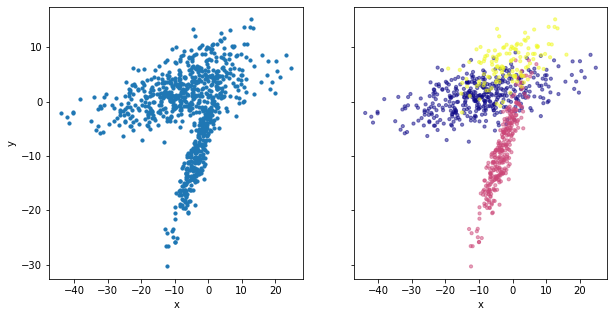

In [3]:
np.random.seed(123)

K = 3   # max 5
Nk = [400, 300, 125, 100, 75]

# for generating random centers
center = np.array((0,0))
dispersion = 2

mu_k = multivariate_normal(center, np.identity(2)*dispersion, K)
sd_k = uniform(0.1, 2, size=K)
data, labels = make_blobs(n_samples=Nk[:K], n_features=2, centers=mu_k, cluster_std=sd_k)

# rotate data in each cluster using random covariance matrices..
sigmas = wishart.rvs(2, scale=np.identity(2), size=K) + np.identity(2)

x = data[labels==0] @ sigmas[0]
for k in range(1,K):
    x = np.vstack((x, data[labels==k] @ sigmas[k]))
data = x
labels = np.sort(labels)

d = pd.DataFrame({'x': data[:,0], 'y':data[:,1], 'labels':labels})

fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(10)
fig.set_figheight(5)

d.plot.scatter(x='x', y='y', ax=axes[0], s=10)
d.plot.scatter(x='x', y='y', c=labels, colorbar=False, colormap='plasma', ax=axes[1], s=10, alpha=0.5);

Now run kmeans/EM using class for updating parameters and visualize 

start demo with K=3
	iteration 0..
	iteration 1..
	iteration 2..
	iteration 3..
	iteration 4..
	iteration 5..


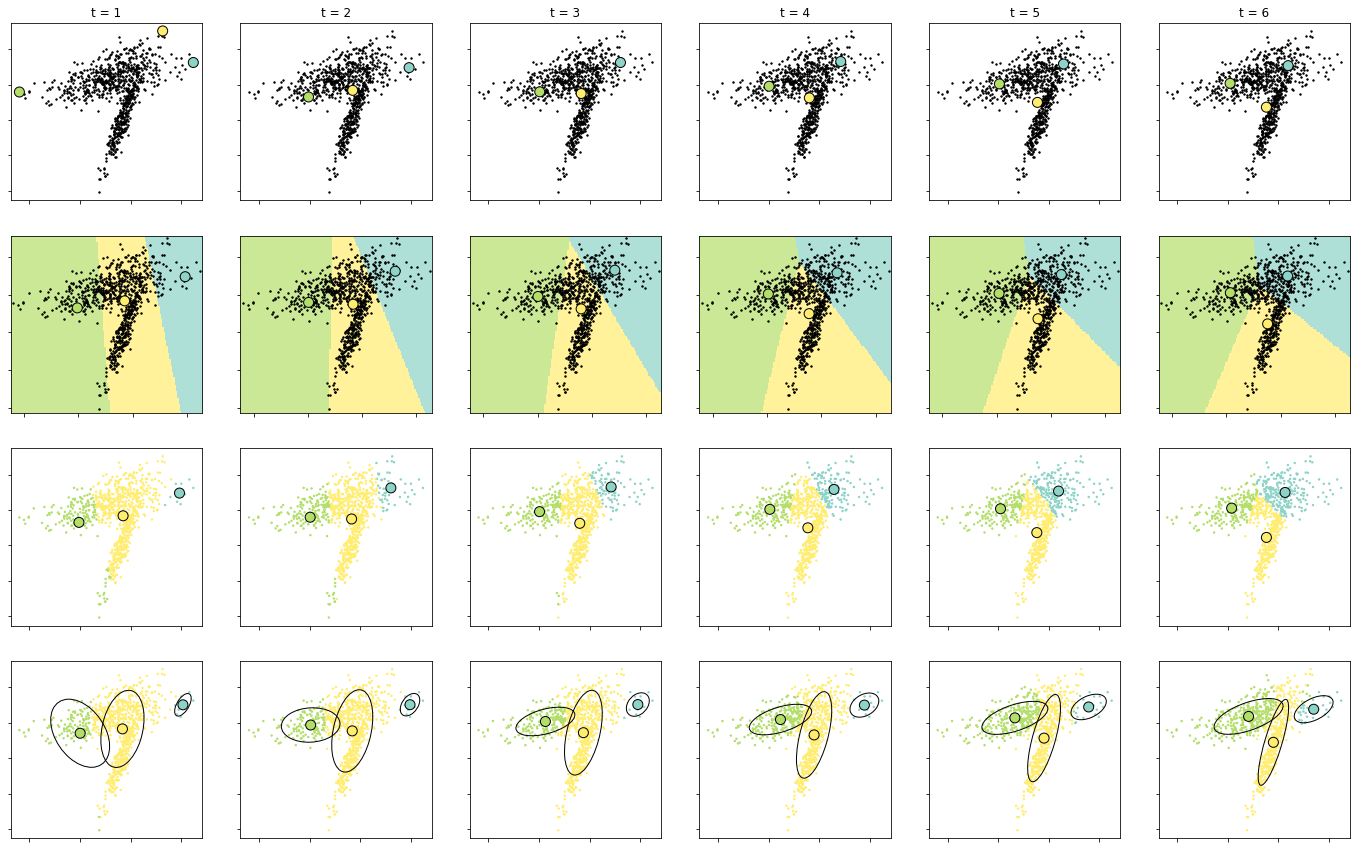

In [10]:
from em_kmeans import K_Means, Gm_EM, assign_nearest, draw_ellipse

# some preparations for plotting etc.
x = d[['x','y']].to_numpy()   # numpy version of data

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .5     # point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

### parameters of demo

T = 6  # run for T iterations
K = 3  # nr of clusters
init_mode = 'adversarial'   # possible initializations are 'random', 'adversarial', 'kmeans++'

# setup visualization..
fig = plt.figure(figsize=(T*4, 15))

print(f'start demo with K={K}')
km = K_Means(x, K, init=init_mode)
em = Gm_EM(x, K, init=km.mu)  # use same init as kmeans..

for t in range(T):
    print(f'\titeration {t}..')
    ax = fig.add_subplot(4, T, t+1)
    ax.scatter(x[:,0], x[:,1], c="black", s=2)
    ax.scatter(km.mu[:,0], km.mu[:,1], c=range(K), s=100, edgecolors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f't = {t+1}')

    # update kmeans and em
    km.step()
    em.step(2)
    
    # plot new assignments
    Z = assign_nearest(np.c_[xx.ravel(), yy.ravel()], km.mu)
    Z = Z.reshape(xx.shape)

    ax = fig.add_subplot(4, T, T + t+1)
    ax.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
              aspect="auto", origin="lower", alpha=0.7)
    
    ax.scatter(x[:,0], x[:,1], c="black", s=2)
    ax.scatter(km.mu[:,0], km.mu[:,1], c=range(K), s=100, edgecolors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # plot new centers for kmeans
    ax = fig.add_subplot(4, T, 2*T + t+1)
    ax.scatter(x[:,0], x[:,1], c=km.labels, s=2)
    ax.scatter(km.mu[:,0], km.mu[:,1], c=range(K), s=100, edgecolors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # plot new parameters for em
    ax = fig.add_subplot(4, T, 3*T + t+1)
    ax.scatter(x[:,0], x[:,1], s=2, c=em.gamma.argmax(axis=1))
    ax.scatter(em.mu[:,0], em.mu[:,1], s=100, c=range(K), edgecolors = 'black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for k in range(em.K):
        ell, transf = draw_ellipse(em.mu[k,:], em.sigma[k,:,:], confint=75)
        ell.set_transform(transf + ax.transData)
        ax.add_patch(ell)
    
    